<font color='red'>Review</font>
- Do sprawdzenia. Czy atrybut `fitness` klasyfikatora nie powinien rosnąć razem z `prediction`?
- Ostatni wykres nie ma sensu. Jak algorytm uruchamiany jest przez `explore` to liczba kroków nie będzie optymalna w większości przypadków. Trzeba by dać albo `explore_exploit` albo samo `exploit` (jako drugą metodę) i narysować liczbę kroków dla tej właśnie fazy
- Czy metryka `knowledge` której używasz jest gdzieś opisana w literaturze? Wypada tu dosyć słabo

In [12]:
# logging 
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# environment setup
import gym
# noinspection PyUnresolvedReferences
import gym_maze

from lcs.agents.xcs import XCS, Configuration

In [2]:
maze = gym.make('Maze4-v0')
print("This is how maze looks like")
situation = maze.reset()
print(type(situation))
print(situation)
maze.render()

This is how maze looks like
<class 'list'>
['1', '1', '0', '0', '1', '0', '1', '1']

■ ■ ■ ■ ■ ■ ■ ■
■ □ □ ■ A □ $ ■
■ ■ □ □ ■ □ □ ■
■ ■ □ ■ □ □ ■ ■
■ □ □ □ □ □ □ ■
■ ■ □ ■ □ □ □ ■
■ □ □ □ □ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■


In [5]:
def xcs_maze_knowledge(population, environment) -> float:
    transitions = environment.env.get_transitions()
    nr_correct = 0
    for start, action, end in transitions:
        perception = environment.env.maze.perception(start)
        if any([True for cl in population
                if cl.does_match(perception) and
                cl.action == action and
                cl.fitness > 0.05 and cl.experience > 10
               ]):
            nr_correct += 1
    return nr_correct / len(transitions)

def xcs_maze_metrics(xcs: XCS, environment):
    return {
        'numerosity': xcs.population.numerosity,
        'knowledge': xcs_maze_knowledge(xcs.population, environment),
        'population': len(xcs.population)
    }

In [6]:
cfg = Configuration(number_of_actions=8,
                    max_population=500,
                    metrics_trial_frequency=50,
                    covering_wildcard_chance = 0.9,
                    user_metrics_collector_fcn=xcs_maze_metrics)

agent = XCS(cfg)
explore_population, explore_metrics = agent.explore(maze, 1000, False)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 50, 'reward': [2.666550160122818e-41, 2.018274221843763e-40, 1.5986416160176578e-40, 3.0220400242567173e-40, 1.8839694805301125e-40, 1.9377468229260098e-40, 1.7406560882840083e-40, 1.2710915976697865e-40], 'perf_time': 0.02321201900485903, 'numerosity': 97, 'knowledge': 0.0, 'population': 77}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 50, 'reward': [10.23013897854688, 58.83872539826588, 6.533201374861085, 7.942495348003256, 7.389133292758752, 7.370614966150676, 8.89229758101736, 6.325032488508073], 'perf_time': 0.021427483996376395, 'numerosity': 314, 'knowledge': 0.10434782608695652, 'population': 200}
INFO:lcs.agents.Agent:{'trial': 200, 'steps_in_trial': 50, 'reward': [35.14724300980908, 29.15153224959911, 58.243851091895195, 17.063169818053606, 13.3385426124155, 15.202872809322015, 14.810935757861865, 19.282845006682074], 'perf_time': 0.021172558001126163, 'numerosity': 326, 'knowledge': 0.12173913043478261, 'populati

In [9]:
len(explore_population)

200

In [8]:
for cl in sorted(explore_population, key=lambda cl: -cl.prediction)[:10]:
    print(str(cl))

Cond:0010001# - Act:0 - Num:3 [fit: 0.000, exp: 364.00, pred: 268.700]
Cond:#10#0110 - Act:2 - Num:3 [fit: 0.000, exp: 120.00, pred: 255.609]
Cond:0#000000 - Act:0 - Num:1 [fit: 0.000, exp: 335.00, pred: 244.954]
Cond:01111110 - Act:0 - Num:1 [fit: 0.000, exp: 225.00, pred: 232.206]
Cond:1010#000 - Act:2 - Num:1 [fit: 0.000, exp: 215.00, pred: 216.855]
Cond:011101#0 - Act:0 - Num:1 [fit: 0.000, exp: 482.00, pred: 215.448]
Cond:10101000 - Act:0 - Num:1 [fit: 0.000, exp: 362.00, pred: 213.661]
Cond:10000010 - Act:7 - Num:1 [fit: 0.000, exp: 66.00, pred: 207.111]
Cond:1#10#101 - Act:3 - Num:3 [fit: 0.059, exp: 398.00, pred: 204.668]
Cond:1##01000 - Act:4 - Num:1 [fit: 0.000, exp: 132.00, pred: 204.558]


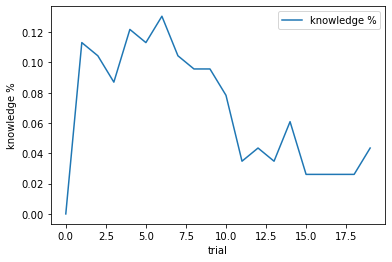

In [13]:
df = pd.DataFrame(metric["knowledge"] for metric in explore_metrics)

ax = df.plot()
ax.set_xlabel("trial")
ax.set_ylabel("knowledge %")
ax.legend(["knowledge %"])

plt.show()

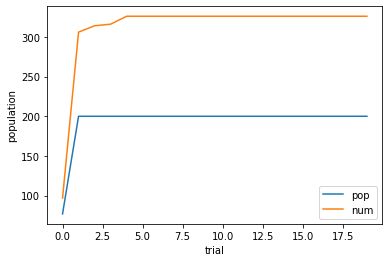

In [15]:
df = pd.DataFrame(zip([metric["population"] for metric in explore_metrics], [metric["numerosity"] for metric in explore_metrics]))

ax = df.plot()
ax.set_xlabel("trial")
ax.set_ylabel("population")
ax.legend(["pop", "num"])

plt.show()

It is hard to say but oking at amount of times algorithm reaches top steps (50) the steps might actually go down over trials.  need to somehow smooth it to see it better

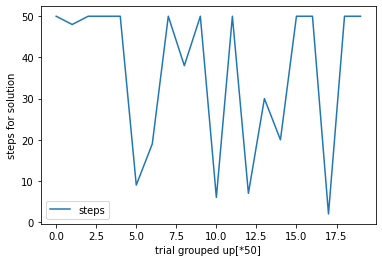

In [16]:
steps_averaged = []


xf = [metric["steps_in_trial"] for metric in explore_metrics]
temp_df = np.array_split(xf, 20)
for i in range(len(temp_df)):
    temp_df[i] = np.mean(temp_df[i]) 
df = pd.DataFrame(temp_df)
# df = pd.DataFrame(metric["steps_in_trial"] for metric in explore_metrics)
ax = df.plot()
ax.set_xlabel("trial grouped up[*50]")
ax.set_ylabel("steps for solution")
ax.legend(["steps"])